<a href="https://colab.research.google.com/github/sajan-npn/text_analysis/blob/main/content_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/paper3/content analysis')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# Cell 1: Install required packages (if needed)
!pip install pandas numpy matplotlib seaborn

# Import libraries
import pandas as pd
import numpy as np
import re
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

# Configure visualisation settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Libraries loaded successfully")


✓ Libraries loaded successfully


In [23]:
# Cell 2: Upload CSV file from your computer
print("Please upload your CSV file:")
uploaded = files.upload()

# Get the filename
filename = list(uploaded.keys())[0]
print(f"\n✓ File uploaded: {filename}")

# Load the data to preview
data_preview = pd.read_csv(filename)
print(f"\nDataset shape: {data_preview.shape}")
print(f"Columns: {list(data_preview.columns)}")
print("\nFirst few rows:")
data_preview.head()

Please upload your CSV file:


Saving comments_7eq1.csv to comments_7eq1.csv

✓ File uploaded: comments_7eq1.csv

Dataset shape: (2647, 33)
Columns: ['respondent_id', 'eq_publicid', 'year', 'location_during_eq', 'location_during_eq_others', 'doing_during_eq', 'doing_during_eq_others', 'felt_earthquake', 'description_shaking', 'description_shaking_others', 'first_response_shaking', 'first_response_shaking_others', 'reaction_shaking', 'reaction_shaking_others', 'built_environment', 'effects_no_visible_effects', 'gender', 'final_comments', 'Unnamed: 18', 'felt_rapid_response', 'felt_earthquake_seconds', 'year_of_birth', 'which_floor_were_you_on', 'total_number_of_storeys', 'age_group', 'injury', 'addressid', 'cleaned_comments', 'tokens', 'filtered_tokens', 'lemmatised_tokens', 'final_cleaned_comments', 'word count']

First few rows:


,respondent_id,eq_publicid,year,location_during_eq,location_during_eq_others,doing_during_eq,doing_during_eq_others,felt_earthquake,description_shaking,description_shaking_others,...,total_number_of_storeys,age_group,injury,addressid,cleaned_comments,tokens,filtered_tokens,lemmatised_tokens,final_cleaned_comments,word count
0,1,2023p122368,2023,Indoors,NaN,Sitting/lying,NaN,Yes,Strong,NaN,...,2.0,30-39,No,1696517.0,the shaking was significant and lengthy,"['the', 'shaking', 'was', 'significant', 'and'...","['shaking', 'significant', 'lengthy']","['shaking', 'significant', 'lengthy']",shaking significant lengthy,3
1,2,2023p122368,2023,Indoors,NaN,Sitting/lying,NaN,Yes,"A jolt or mild, but unmistakably an earthquake...",NaN,...,NaN,18-29,No,543388.0,i could hear it for a good seconds before it hit,"['i', 'could', 'hear', 'it', 'for', 'a', 'good...","['could', 'hear', 'good', 'seconds', 'hit']","['could', 'hear', 'good', 'second', 'hit']",could hear good second hit,5
2,3,2023p122368,2023,Indoors,NaN,Sitting/lying,NaN,Yes,Strong,NaN,...,NaN,70-79,No,309277.0,that was exciting,"['that', 'was', 'exciting']",['exciting'],['exciting'],exciting,1
3,4,2023p122368,2023,Indoors,NaN,Sitting/lying,NaN,Yes,Moderate,NaN,...,NaN,40-49,No,1605984.0,mm pile build she sure did jolt,"['mm', 'pile', 'build', 'she', 'sure', 'did', ...","['mm', 'pile', 'build', 'sure', 'jolt']","['mm', 'pile', 'build', 'sure', 'jolt']",mm pile build sure jolt,5
4,5,2023p122368,2023,Indoors,NaN,Sitting/lying,NaN,Yes,Moderate,NaN,...,NaN,60-69,No,349440.0,rumble and then strong jolt and shake slight g...,"['rumble', 'and', 'then', 'strong', 'jolt', 'a...","['rumble', 'strong', 'jolt', 'shake', 'slight'...","['rumble', 'strong', 'jolt', 'shake', 'slight'...",rumble strong jolt shake slight gap another jolt,8


In [24]:
# Cell 3: Load the complete InformationSeekingAnalyser class

class InformationSeekingAnalyser:
    """
    Framework for conducting summative content analysis of information-seeking
    behaviour in disaster contexts.
    """

    def __init__(self):
        self.data = None
        self.info_seeking_terms = []
        self.alternative_terms = []
        self.text_columns = []
        self.intensity_col = None
        self.emotion_col = None
        self.behaviour_col = None
        self.datetime_col = None
        self.results = {}

    def load_csv_data(self, filepath, encoding='utf-8'):
        try:
            self.data = pd.read_csv(filepath, encoding=encoding)
            print(f"✓ Data loaded: {len(self.data)} records")
            print(f"\nAvailable columns:\n{list(self.data.columns)}")
            return self.data
        except Exception as e:
            print(f"✗ Error loading CSV: {str(e)}")
            return None

    def set_text_columns(self, column_list):
        """Set text columns programmatically for Colab"""
        self.text_columns = [col.strip() for col in column_list]
        invalid_cols = [col for col in self.text_columns if col not in self.data.columns]
        if invalid_cols:
            print(f"⚠ Warning: These columns were not found: {invalid_cols}")
            self.text_columns = [col for col in self.text_columns if col in self.data.columns]
        print(f"✓ Using text columns: {self.text_columns}")

    def set_search_terms(self, info_terms, alt_terms=None):
        """Set search terms programmatically for Colab"""
        self.info_seeking_terms = [term.strip().lower() for term in info_terms]
        print(f"✓ Information-seeking terms: {self.info_seeking_terms}")

        if alt_terms:
            self.alternative_terms = [term.strip().lower() for term in alt_terms]
            print(f"✓ Alternative terms: {self.alternative_terms}")

    def set_contextual_columns(self, intensity=None, emotion=None, behaviour=None, datetime=None):
        """Set contextual variable columns programmatically for Colab"""
        self.intensity_col = intensity
        self.emotion_col = emotion
        self.behaviour_col = behaviour
        self.datetime_col = datetime

        print("✓ Contextual variables configured:")
        if intensity: print(f"  - Intensity: {intensity}")
        if emotion: print(f"  - Emotion: {emotion}")
        if behaviour: print(f"  - Behaviour: {behaviour}")
        if datetime: print(f"  - DateTime: {datetime}")

    def count_terms_in_text(self, text, term_list):
        if pd.isna(text):
            return {term: 0 for term in term_list}

        text_lower = str(text).lower()
        counts = {}

        for term in term_list:
            if ' ' in term:
                pattern = re.escape(term)
            else:
                pattern = r'\b' + re.escape(term) + r'\b'
            matches = re.findall(pattern, text_lower)
            counts[term] = len(matches)
        return counts

    def extract_combined_text(self, row):
        texts = []
        for col in self.text_columns:
            if col in row.index and not pd.isna(row[col]):
                texts.append(str(row[col]))
        return ' '.join(texts)

    def analyse_information_seeking(self):
        if self.data is None or not self.info_seeking_terms:
            print("✗ Please load data and configure analysis first")
            return None

        print("⟳ Commencing analysis...")
        analysis_records = []

        for idx, row in self.data.iterrows():
            combined_text = self.extract_combined_text(row)
            if not combined_text.strip():
                continue

            info_counts = self.count_terms_in_text(combined_text, self.info_seeking_terms)
            total_info_seeking = sum(info_counts.values())

            alt_counts = {}
            total_alternative = 0
            if self.alternative_terms:
                alt_counts = self.count_terms_in_text(combined_text, self.alternative_terms)
                total_alternative = sum(alt_counts.values())

            total_words = len(combined_text.split())
            total_info_related = total_info_seeking + total_alternative

            record = {
                'record_id': idx,
                'text_length_words': total_words,
                'info_seeking_count': total_info_seeking,
                'alternative_count': total_alternative,
                'total_info_related': total_info_related,
                'info_seeking_per_100_words': (total_info_seeking / total_words * 100) if total_words > 0 else 0,
                'alternative_per_100_words': (total_alternative / total_words * 100) if total_words > 0 else 0,
                'info_seeking_proportion': (total_info_seeking / total_info_related) if total_info_related > 0 else np.nan,
                'alternative_proportion': (total_alternative / total_info_related) if total_info_related > 0 else np.nan,
            }

            for term, count in info_counts.items():
                record[f'term_{term}'] = count
            for term, count in alt_counts.items():
                record[f'alt_{term}'] = count

            if self.intensity_col and self.intensity_col in row.index:
                record['intensity'] = row[self.intensity_col]
            if self.emotion_col and self.emotion_col in row.index:
                record['emotion'] = row[self.emotion_col]
            if self.behaviour_col and self.behaviour_col in row.index:
                record['behavioural_response'] = row[self.behaviour_col]
            if self.datetime_col and self.datetime_col in row.index:
                record['earthquake_datetime'] = row[self.datetime_col]
                try:
                    dt = pd.to_datetime(row[self.datetime_col])
                    record['hour_of_day'] = dt.hour
                    record['day_of_week'] = dt.dayofweek
                    record['time_period'] = self._categorise_time_period(dt.hour)
                except:
                    pass

            analysis_records.append(record)

        results_df = pd.DataFrame(analysis_records)
        self.results['main_analysis'] = results_df
        print(f"✓ Analysis complete: {len(results_df)} records processed")
        return results_df

    def _categorise_time_period(self, hour):
        if 6 <= hour < 12:
            return 'morning'
        elif 12 <= hour < 18:
            return 'afternoon'
        elif 18 <= hour < 22:
            return 'evening'
        else:
            return 'night'

    def generate_frequency_tables(self):
        if 'main_analysis' not in self.results:
            print("✗ Please run analyse_information_seeking() first")
            return None

        df = self.results['main_analysis']
        tables = {}

        desc_stats = df[['info_seeking_count', 'alternative_count',
                         'total_info_related', 'info_seeking_per_100_words']].describe()
        tables['overall_statistics'] = desc_stats

        if 'intensity' in df.columns and df['intensity'].notna().any():
            intensity_table = df.groupby('intensity').agg({
                'info_seeking_count': ['count', 'mean', 'std', 'sum'],
                'alternative_count': ['mean', 'std', 'sum'],
                'info_seeking_proportion': ['mean', 'std']
            }).round(3)
            tables['by_intensity'] = intensity_table

        if 'emotion' in df.columns and df['emotion'].notna().any():
            emotion_table = df.groupby('emotion').agg({
                'info_seeking_count': ['count', 'mean', 'std', 'sum'],
                'alternative_count': ['mean', 'std', 'sum'],
                'info_seeking_per_100_words': ['mean', 'std']
            }).round(3)
            tables['by_emotion'] = emotion_table

        if 'behavioural_response' in df.columns and df['behavioural_response'].notna().any():
            behaviour_table = df.groupby('behavioural_response').agg({
                'info_seeking_count': ['count', 'mean', 'std', 'sum'],
                'total_info_related': ['mean', 'std']
            }).round(3)
            tables['by_behaviour'] = behaviour_table

        if 'time_period' in df.columns and df['time_period'].notna().any():
            time_table = df.groupby('time_period').agg({
                'info_seeking_count': ['count', 'mean', 'std'],
                'alternative_count': ['mean', 'std']
            }).round(3)
            tables['by_time_period'] = time_table

        self.results['frequency_tables'] = tables
        return tables

    def visualise_patterns(self):
        if 'main_analysis' not in self.results:
            print("✗ Please run analyse_information_seeking() first")
            return None

        df = self.results['main_analysis']

        n_plots = 2
        if 'intensity' in df.columns and df['intensity'].notna().any():
            n_plots += 1
        if 'emotion' in df.columns and df['emotion'].notna().any():
            n_plots += 1

        fig = plt.figure(figsize=(16, 4 * ((n_plots + 1) // 2)))
        plot_idx = 1

        plt.subplot(2, 2, plot_idx)
        plt.hist(df['info_seeking_per_100_words'], bins=20, alpha=0.7, color='steelblue', edgecolor='black')
        plt.xlabel('Information-Seeking Terms per 100 Words')
        plt.ylabel('Frequency')
        plt.title('Distribution of Information-Seeking Linguistic Intensity')
        plt.grid(axis='y', alpha=0.3)
        plot_idx += 1

        plt.subplot(2, 2, plot_idx)
        term_means = [df['info_seeking_count'].mean(), df['alternative_count'].mean()]
        plt.bar(['Direct Info-Seeking', 'Alternative Terms'], term_means,
                color=['steelblue', 'coral'], alpha=0.8, edgecolor='black')
        plt.ylabel('Mean Count per Response')
        plt.title('Average Frequency: Direct vs Alternative Terminology')
        plt.grid(axis='y', alpha=0.3)
        plot_idx += 1

        if 'intensity' in df.columns and df['intensity'].notna().any():
            plt.subplot(2, 2, plot_idx)
            intensity_means = df.groupby('intensity')['info_seeking_per_100_words'].mean().sort_index()
            intensity_means.plot(kind='bar', color='steelblue', alpha=0.8, edgecolor='black')
            plt.xlabel('Earthquake Intensity')
            plt.ylabel('Mean Info-Seeking Terms per 100 Words')
            plt.title('Information-Seeking Behaviour by Earthquake Intensity')
            plt.xticks(rotation=45)
            plt.grid(axis='y', alpha=0.3)
            plot_idx += 1

        if 'emotion' in df.columns and df['emotion'].notna().any():
            plt.subplot(2, 2, plot_idx)
            emotion_data = df.groupby('emotion')[['info_seeking_count', 'alternative_count']].mean()
            emotion_data.plot(kind='bar', color=['steelblue', 'coral'], alpha=0.8, edgecolor='black')
            plt.xlabel('Emotional State')
            plt.ylabel('Mean Term Count')
            plt.title('Information-Seeking by Emotional Response')
            plt.legend(['Direct', 'Alternative'])
            plt.xticks(rotation=45)
            plt.grid(axis='y', alpha=0.3)
            plot_idx += 1

        plt.tight_layout()
        return fig

print("✓ InformationSeekingAnalyser class loaded successfully")

✓ InformationSeekingAnalyser class loaded successfully


In [25]:
# Cell 4: Create analyser instance and load your data

# Initialize
analyser = InformationSeekingAnalyser()

# Load the CSV file (use the filename from Step 2)
data = analyser.load_csv_data(filename)

# Preview the data
print("\n" + "="*70)
print("DATA PREVIEW")
print("="*70)
data.head()

✓ Data loaded: 2647 records

Available columns:
['respondent_id', 'eq_publicid', 'year', 'location_during_eq', 'location_during_eq_others', 'doing_during_eq', 'doing_during_eq_others', 'felt_earthquake', 'description_shaking', 'description_shaking_others', 'first_response_shaking', 'first_response_shaking_others', 'reaction_shaking', 'reaction_shaking_others', 'built_environment', 'effects_no_visible_effects', 'gender', 'final_comments', 'Unnamed: 18', 'felt_rapid_response', 'felt_earthquake_seconds', 'year_of_birth', 'which_floor_were_you_on', 'total_number_of_storeys', 'age_group', 'injury', 'addressid', 'cleaned_comments', 'tokens', 'filtered_tokens', 'lemmatised_tokens', 'final_cleaned_comments', 'word count']

DATA PREVIEW


,respondent_id,eq_publicid,year,location_during_eq,location_during_eq_others,doing_during_eq,doing_during_eq_others,felt_earthquake,description_shaking,description_shaking_others,...,total_number_of_storeys,age_group,injury,addressid,cleaned_comments,tokens,filtered_tokens,lemmatised_tokens,final_cleaned_comments,word count
0,1,2023p122368,2023,Indoors,NaN,Sitting/lying,NaN,Yes,Strong,NaN,...,2.0,30-39,No,1696517.0,the shaking was significant and lengthy,"['the', 'shaking', 'was', 'significant', 'and'...","['shaking', 'significant', 'lengthy']","['shaking', 'significant', 'lengthy']",shaking significant lengthy,3
1,2,2023p122368,2023,Indoors,NaN,Sitting/lying,NaN,Yes,"A jolt or mild, but unmistakably an earthquake...",NaN,...,NaN,18-29,No,543388.0,i could hear it for a good seconds before it hit,"['i', 'could', 'hear', 'it', 'for', 'a', 'good...","['could', 'hear', 'good', 'seconds', 'hit']","['could', 'hear', 'good', 'second', 'hit']",could hear good second hit,5
2,3,2023p122368,2023,Indoors,NaN,Sitting/lying,NaN,Yes,Strong,NaN,...,NaN,70-79,No,309277.0,that was exciting,"['that', 'was', 'exciting']",['exciting'],['exciting'],exciting,1
3,4,2023p122368,2023,Indoors,NaN,Sitting/lying,NaN,Yes,Moderate,NaN,...,NaN,40-49,No,1605984.0,mm pile build she sure did jolt,"['mm', 'pile', 'build', 'she', 'sure', 'did', ...","['mm', 'pile', 'build', 'sure', 'jolt']","['mm', 'pile', 'build', 'sure', 'jolt']",mm pile build sure jolt,5
4,5,2023p122368,2023,Indoors,NaN,Sitting/lying,NaN,Yes,Moderate,NaN,...,NaN,60-69,No,349440.0,rumble and then strong jolt and shake slight g...,"['rumble', 'and', 'then', 'strong', 'jolt', 'a...","['rumble', 'strong', 'jolt', 'shake', 'slight'...","['rumble', 'strong', 'jolt', 'shake', 'slight'...",rumble strong jolt shake slight gap another jolt,8


In [30]:
# Cell 5: Configure your analysis parameters

# IMPORTANT: Modify these lists based on your column names and research focus

# 1. Specify your text/comment columns
text_columns = ['final_cleaned_comments']  # ← CHANGE THESE to your actual column names

# 2. Define information-seeking terms
info_seeking_terms = [
    'information', 'know', 'learn', 'understand', 'update', 'updates',
    'find out', 'search', 'ask', 'inquire', 'discover', 'access'
]  # ← ADD or REMOVE terms as needed

# 3. Define alternative/related terms (optional)
#alternative_terms = [
    #'confused', 'uncertain', 'clarity', 'guidance',
    #'help', 'unsure', 'wonder', 'question'
#]  # ← ADD or REMOVE terms as needed, or set to None

# 4. Specify contextual variable columns (use None if not available)
intensity_column = 'description_shaking'      # ← Your intensity column name, or None
emotion_column = 'reaction_shaking'          # ← Your emotion column name, or None
behaviour_column = 'first_response_shaking'      # ← Your behaviour column name, or None
#datetime_column = 'earthquake_time' # ← Your datetime column name, or None
id_column = 'respondent_id'             # <- Your unique id

# Apply configuration
print("=" * 70)
print("CONFIGURING ANALYSIS")
print("=" * 70 + "\n")

analyser.set_text_columns(text_columns)
print()
analyser.set_search_terms(info_seeking_terms) #,alternative_terms)
print()
analyser.set_contextual_columns(
    intensity=intensity_column,
    emotion=emotion_column,
    behaviour=behaviour_column
    #datetime=datetime_column
    #id=id_column  # Removed this line as 'id' is not a valid parameter for set_contextual_columns
)

print("\n" + "=" * 70)
print("CONFIGURATION COMPLETE")
print("=" * 70)

CONFIGURING ANALYSIS

✓ Using text columns: ['final_cleaned_comments']

✓ Information-seeking terms: ['information', 'know', 'learn', 'understand', 'update', 'updates', 'find out', 'search', 'ask', 'inquire', 'discover', 'access']

✓ Contextual variables configured:
  - Intensity: description_shaking
  - Emotion: reaction_shaking
  - Behaviour: first_response_shaking

CONFIGURATION COMPLETE


In [31]:
# Cell 6: Perform Information-Seeking Analysis

print("=" * 70)
print("PERFORMING ANALYSIS")
print("=" * 70 + "\n")

analysis_results = analyser.analyse_information_seeking()

if analysis_results is not None:
    print("\nAnalysis completed successfully. First 5 rows of results:")
    print(analysis_results.head())
else:
    print("Analysis failed or no results were generated.")


PERFORMING ANALYSIS

⟳ Commencing analysis...
✓ Analysis complete: 2642 records processed

Analysis completed successfully. First 5 rows of results:
   record_id  text_length_words  info_seeking_count  alternative_count  \
0          0                  3                   0                  0   
1          1                  5                   0                  0   
2          2                  1                   0                  0   
3          3                  5                   0                  0   
4          4                  8                   0                  0   

   total_info_related  info_seeking_per_100_words  alternative_per_100_words  \
0                   0                         0.0                        0.0   
1                   0                         0.0                        0.0   
2                   0                         0.0                        0.0   
3                   0                         0.0                        0.0   
4     

In [32]:
# Cell 7: Generate and display frequency tables

print("=" * 70)
print("FREQUENCY TABLES")
print("=" * 70 + "\n")

tables = analyser.generate_frequency_tables()

if tables:
    print("OVERALL STATISTICS")
    print("-" * 70)
    display(tables['overall_statistics'])

    if 'by_intensity' in tables:
        print("\n\nPATTERNS BY EARTHQUAKE INTENSITY")
        print("-" * 70)
        display(tables['by_intensity'])

    if 'by_emotion' in tables:
        print("\n\nPATTERNS BY EMOTIONAL STATE")
        print("-" * 70)
        display(tables['by_emotion'])

    if 'by_behaviour' in tables:
        print("\n\nPATTERNS BY BEHAVIOURAL RESPONSE")
        print("-" * 70)
        display(tables['by_behaviour'])

    if 'by_time_period' in tables:
        print("\n\nPATTERNS BY TIME PERIOD")
        print("-" * 70)
        display(tables['by_time_period'])

FREQUENCY TABLES

OVERALL STATISTICS
----------------------------------------------------------------------


,info_seeking_count,alternative_count,total_info_related,info_seeking_per_100_words
count,2642.000000,2642.0,2642.000000,2642.000000
mean,0.148372,0.0,0.148372,1.483958
std,0.428905,0.0,0.428905,5.423675
min,0.000000,0.0,0.000000,0.000000
25%,0.000000,0.0,0.000000,0.000000
50%,0.000000,0.0,0.000000,0.000000
75%,0.000000,0.0,0.000000,0.000000
max,3.000000,0.0,3.000000,100.000000




PATTERNS BY EARTHQUAKE INTENSITY
----------------------------------------------------------------------


info_seeking_count         \
                                                                count   mean   
intensity                                                                      
A jolt or mild, but unmistakably an earthquake ...                338  0.107   
Gentle, hardly recognized as an earthquake (lik...                171  0.047   
Heard, but not felt                                                15  0.267   
Moderate                                                          737  0.103   
Other (please specify)                                            413  0.191   
Severe                                                              3  0.000   
Strong                                                             80  0.000   
Strong powerful                                                   692  0.201   
Violent severe                                                    162  0.309   

                                                                \
                                                      std  sum   
intensity                                                        
A jolt or mild, but unmistakably an earthquake ...  0.362   36   
Gentle, hardly recognized as an earthquake (lik...  0.238    8   
Heard, but not felt                                 0.594    4   
Moderate                                            0.342   76   
Other (please specify)                              0.492   79   
Severe                                              0.000    0   
Strong                                              0.000    0   
Strong powerful                                     0.477  139   
Violent severe                                      0.662   50   

                                                   alternative_count           \
                                                                mean  std sum   
intensity                                                                       
A jolt or mild, but unmistakably an earthquake ...               0.0  0.0   0   
Gentle, hardly recognized as an earthquake (lik...               0.0  0.0   0   
Heard, but not felt                                              0.0  0.0   0   
Moderate                                                         0.0  0.0   0   
Other (please specify)                                           0.0  0.0   0   
Severe                                                           0.0  0.0   0   
Strong                                                           0.0  0.0   0   
Strong powerful                                                  0.0  0.0   0   
Violent severe                                                   0.0  0.0   0   

                                                   info_seeking_proportion  \
                                                                      mean   
intensity                                                                    
A jolt or mild, but unmistakably an earthquake ...                     1.0   
Gentle, hardly recognized as an earthquake (lik...                     1.0   
Heard, but not felt                                                    1.0   
Moderate                                                               1.0   
Other (please specify)                                                 1.0   
Severe                                                                 NaN   
Strong                                                                 NaN   
Strong powerful                                                        1.0   
Violent severe                                                         1.0   

                                                         
                                                    std  
intensity                                                
A jolt or mild, but unmistakably an earthquake ...  0.0  
Gentle, hardly recognized as an earthquake (lik...  0.0  
Heard, but not felt                                 0.0  
Moderate                               



PATTERNS BY EMOTIONAL STATE
----------------------------------------------------------------------


info_seeking_count                     \
                                       count   mean    std  sum   
emotion                                                           
A bit frightened                         936  0.139  0.406  130   
Don't know/Not applicable                  8  0.125  0.354    1   
Excited but not alarmed                  558  0.115  0.390   64   
Extremely frightened                     186  0.226  0.491   42   
No reaction                               40  0.100  0.379    4   
Other (please specify)                   286  0.147  0.410   42   
Very frightened                          341  0.249  0.547   85   
Very little reaction                     253  0.095  0.397   24   

                          alternative_count           \
                                       mean  std sum   
emotion                                                
A bit frightened                        0.0  0.0   0   
Don't know/Not applicable               0.0  0.0   0   
Excited but not alarmed                 0.0  0.0   0   
Extremely frightened                    0.0  0.0   0   
No reaction                             0.0  0.0   0   
Other (please specify)                  0.0  0.0   0   
Very frightened                         0.0  0.0   0   
Very little reaction                    0.0  0.0   0   

                          info_seeking_per_100_words         
                                                mean    std  
emotion                                                      
A bit frightened                               1.553  5.465  
Don't know/Not applicable                      0.391  1.105  
Excited but not alarmed                        1.031  4.097  
Extremely frightened                           2.296  5.750  
No reaction                                    0.634  2.484  
Other (please specify)                         1.214  4.717  
Very frightened                                2.439  7.784  
Very little reaction                           1.015  5.026



PATTERNS BY BEHAVIOURAL RESPONSE
----------------------------------------------------------------------


info_seeking_count         \
                                                                count   mean   
behavioural_response                                                           
Continued driving                                                   1  0.000   
Continued what I was doing before                                 252  0.075   
Dropped, covered and held                                           9  0.000   
Dropped, covered under a sturdy piece of furnit...                203  0.202   
Immediately left the building I was in                             60  0.100   
Moved to a doorway                                                 39  0.000   
Not applicable                                                      8  0.250   
Other (please explain)                                            647  0.221   
Stopped driving and pulled over to the side of ...                  2  0.000   
Stopped what I was doing but stayed where I was                  1189  0.121   
Tried to protect other people nearby                              163  0.196   
Tried to protect property nearby (e.g., prevent...                 38  0.132   

                                                                \
                                                      std  sum   
behavioural_response                                             
Continued driving                                     NaN    0   
Continued what I was doing before                   0.306   19   
Dropped, covered and held                           0.000    0   
Dropped, covered under a sturdy piece of furnit...  0.501   41   
Immediately left the building I was in              0.399    6   
Moved to a doorway                                  0.000    0   
Not applicable                                      0.463    2   
Other (please explain)                              0.524  143   
Stopped driving and pulled over to the side of ...  0.000    0   
Stopped what I was doing but stayed where I was     0.381  144   
Tried to protect other people nearby                0.470   32   
Tried to protect property nearby (e.g., prevent...  0.414    5   

                                                   total_info_related         
                                                                 mean    std  
behavioural_response                                                          
Continued driving                                               0.000    NaN  
Continued what I was doing before                               0.075  0.306  
Dropped, covered and held                                       0.000  0.000  
Dropped, covered under a sturdy piece of furnit...              0.202  0.501  
Immediately left the building I was in                          0.100  0.399  
Moved to a doorway                                              0.000  0.000  
Not applicable                                                  0.250  0.463  
Other (please explain)                                          0.221  0.524  
Stopped driving and pulled over to the side of ...              0.000  0.000  
Stopped what I was doing but stayed where I was                 0.121  0.381  
Tried to protect other people nearby                            0.196  0.470  
Tried to protect property nearby (e.g., prevent...              0.132  0.414

Generating visualisations...



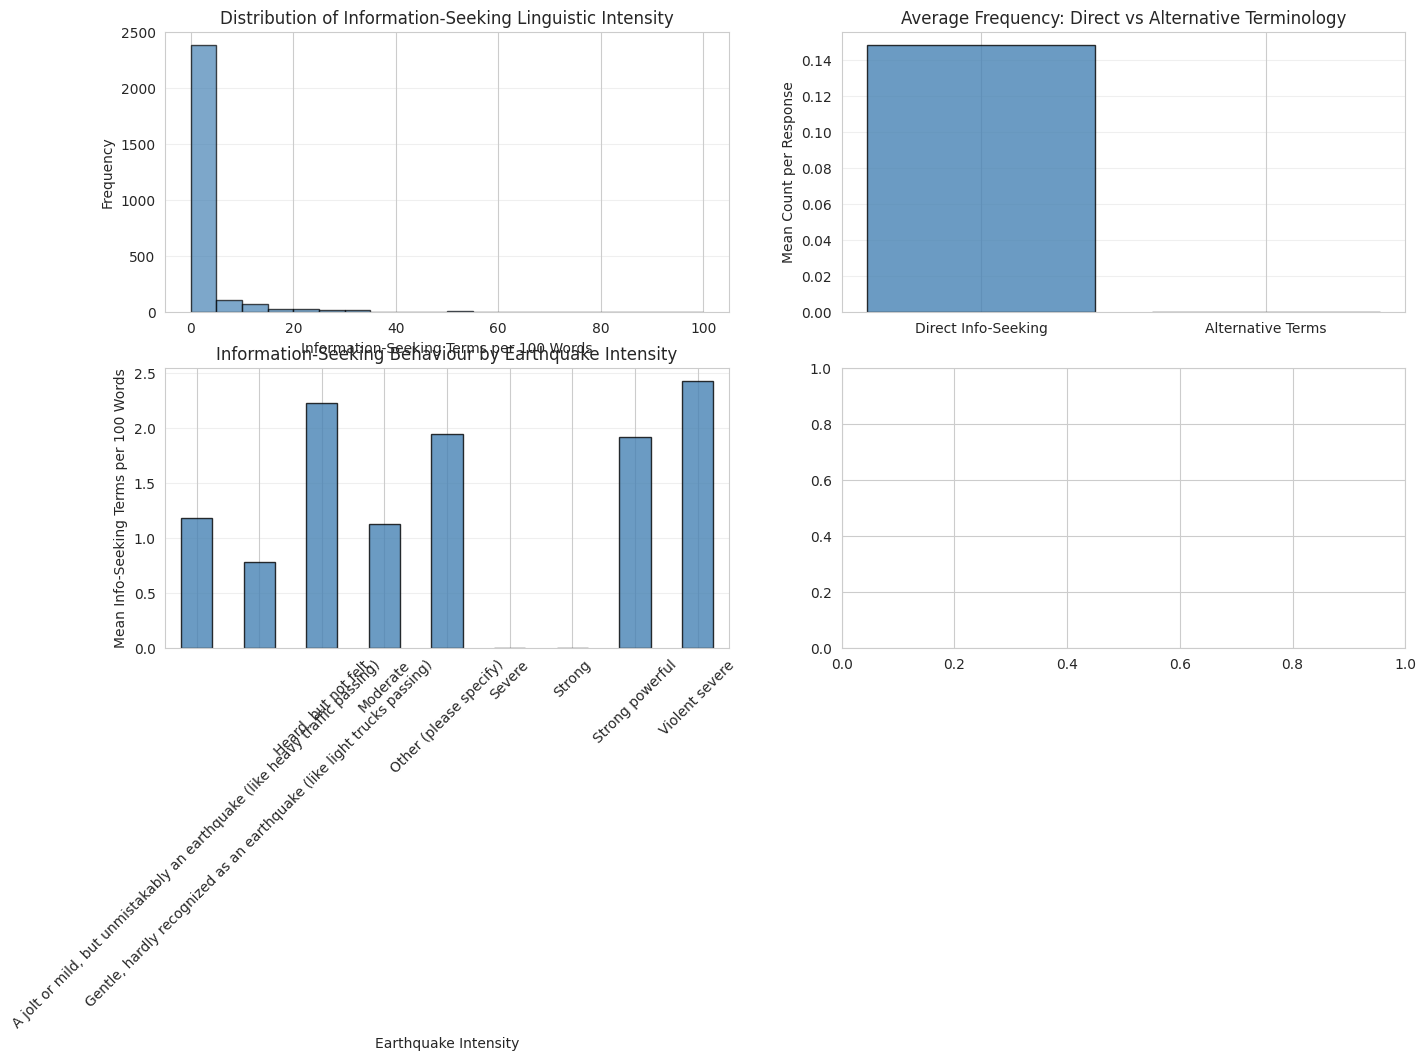

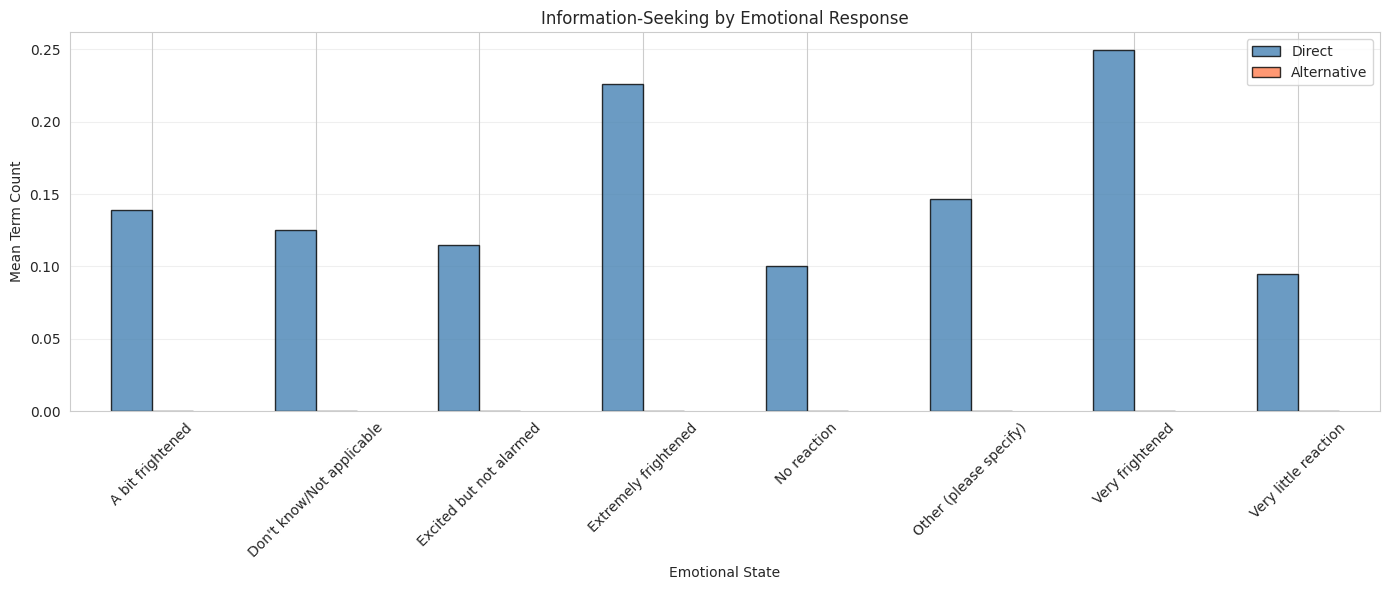


✓ Visualisations generated successfully


In [33]:
# Cell 8: Generate visualisations

print("Generating visualisations...\n")

fig = analyser.visualise_patterns()

if fig:
    plt.show()
    print("\n✓ Visualisations generated successfully")
else:
    print("✗ Unable to generate visualisations")

In [37]:
# Cell 9: Explore specific patterns

if analysis_results is not None:
    print("=" * 70)
    print("ADDITIONAL EXPLORATORY ANALYSIS")
    print("=" * 70 + "\n")

    # Distribution of information-seeking density
    print("1. INFORMATION-SEEKING DENSITY DISTRIBUTION")
    print("-" * 70)
    print(f"Mean: {analysis_results['info_seeking_per_100_words'].mean():.2f}")
    print(f"Median: {analysis_results['info_seeking_per_100_words'].median():.2f}")
    print(f"Std Dev: {analysis_results['info_seeking_per_100_words'].std():.2f}")
    print(f"Range: {analysis_results['info_seeking_per_100_words'].min():.2f} - {analysis_results['info_seeking_per_100_words'].max():.2f}")

    # Compare high vs low intensity (if available)
    if 'intensity' in analysis_results.columns:
        print("\n\n2. HIGH VS LOW INTENSITY COMPARISON")
        print("-" * 70)

        # Define an explicit ordinal mapping for intensity levels
        # Based on visual inspection of the bar chart and typical earthquake scales
        intensity_order = [
            'Heard, but not felt', # Place low, as not perceived
            'Gentle, hardly recognized as an earthquake (like light trucks passing)',
            'A jolt or mild, but unmistakably an earthquake (like heavy traffic passing)',
            'Moderate',
            'Strong',
            'Severe',
            'Strong powerful',
            'Violent severe'
        ]

        # Create a numerical representation of intensity
        # Values not in `intensity_order` (e.g., 'Other (please specify)') will become NaN
        intensity_numeric_map = {category: i for i, category in enumerate(intensity_order)}
        analysis_results['intensity_numeric'] = analysis_results['intensity'].map(intensity_numeric_map)

        # Filter out NaN values (unmapped categories) for median calculation
        numeric_intensity_data = analysis_results['intensity_numeric'].dropna()

        if not numeric_intensity_data.empty:
            median_intensity_numeric = numeric_intensity_data.median()

            # Split into high and low intensity groups based on the numerical median
            high_intensity_df = analysis_results[analysis_results['intensity_numeric'] >= median_intensity_numeric]
            low_intensity_df = analysis_results[analysis_results['intensity_numeric'] < median_intensity_numeric]

            print(f"High Intensity (n={len(high_intensity_df)}):")
            print(f"  Mean info-seeking count: {high_intensity_df['info_seeking_count'].mean():.2f}")
            print(f"  Mean alternative count: {high_intensity_df['alternative_count'].mean():.2f}")
            print(f"  Mean density: {high_intensity_df['info_seeking_per_100_words'].mean():.2f} per 100 words")

            print(f"\nLow Intensity (n={len(low_intensity_df)}):")
            print(f"  Mean info-seeking count: {low_intensity_df['info_seeking_count'].mean():.2f}")
            print(f"  Mean alternative count: {low_intensity_df['alternative_count'].mean():.2f}")
            print(f"  Mean density: {low_intensity_df['info_seeking_per_100_words'].mean():.2f} per 100 words")
        else:
            print("  Could not calculate median intensity for comparison (no valid numeric intensity data).")
    else:
        print("  Intensity column not found for comparison.")

    # Individual term frequencies
    print("\n\n3. INDIVIDUAL TERM FREQUENCIES")
    print("-" * 70)

    term_cols = [col for col in analysis_results.columns if col.startswith('term_')]
    if term_cols:
        term_totals = analysis_results[term_cols].sum().sort_values(ascending=False)
        print("\nDirect information-seeking terms:")
        for term, count in term_totals.items():
            clean_term = term.replace('term_', '')
            print(f"  {clean_term}: {int(count)} occurrences")

    alt_cols = [col for col in analysis_results.columns if col.startswith('alt_')]
    if alt_cols:
        alt_totals = analysis_results[alt_cols].sum().sort_values(ascending=False)
        print("\nAlternative terms:")
        for term, count in alt_totals.items():
            clean_term = term.replace('alt_', '')
            print(f"  {clean_term}: {int(count)} occurrences")

ADDITIONAL EXPLORATORY ANALYSIS

1. INFORMATION-SEEKING DENSITY DISTRIBUTION
----------------------------------------------------------------------
Mean: 1.48
Median: 0.00
Std Dev: 5.42
Range: 0.00 - 100.00


2. HIGH VS LOW INTENSITY COMPARISON
----------------------------------------------------------------------
High Intensity (n=1674):
  Mean info-seeking count: 0.16
  Mean alternative count: 0.00
  Mean density: 1.52 per 100 words

Low Intensity (n=524):
  Mean info-seeking count: 0.09
  Mean alternative count: 0.00
  Mean density: 1.08 per 100 words


3. INDIVIDUAL TERM FREQUENCIES
----------------------------------------------------------------------

Direct information-seeking terms:
  information: 192 occurrences
  know: 100 occurrences
  update: 44 occurrences
  understand: 24 occurrences
  access: 10 occurrences
  learn: 9 occurrences
  ask: 8 occurrences
  discover: 3 occurrences
  search: 2 occurrences
  updates: 0 occurrences
  find out: 0 occurrences
  inquire: 0 occurren

In [39]:
# Cell 10: Download results to your computer

from google.colab import files

print("=" * 70)
print("EXPORTING RESULTS")
print("=" * 70 + "\n")

# Export main results
if analysis_results is not None:
    analysis_results.to_csv('information_seeking_results.csv', index=False)
    print("✓ Main results saved as 'information_seeking_results.csv'")
    files.download('information_seeking_results.csv')

# Export frequency tables to Excel
if tables:
    with pd.ExcelWriter('frequency_tables.xlsx', engine='openpyxl') as writer:
        for name, table in tables.items():
            sheet_name = name[:31]  # Excel sheet name limit
            table.to_excel(writer, sheet_name=sheet_name)
    print("✓ Frequency tables saved as 'frequency_tables.xlsx'")
    files.download('frequency_tables.xlsx')

# Save visualisation
if fig:
    fig.savefig('information_seeking_visualisations.png', dpi=300, bbox_inches='tight')
    print("✓ Visualisations saved as 'information_seeking_visualisations.png'")
    files.download('information_seeking_visualisations.png')

print("\n" + "=" * 70)
print("EXPORT COMPLETE")
print("=" * 70)

EXPORTING RESULTS

✓ Main results saved as 'information_seeking_results.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Frequency tables saved as 'frequency_tables.xlsx'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Visualisations saved as 'information_seeking_visualisations.png'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


EXPORT COMPLETE


In [40]:
# Cell 11: Examine relationships between multiple variables

if analysis_results is not None:
    print("=" * 70)
    print("CROSS-TABULATION ANALYSIS")
    print("=" * 70 + "\n")

    # Cross-tab: Intensity × Emotion
    if 'intensity' in analysis_results.columns and 'emotion' in analysis_results.columns:
        print("1. Mean Information-Seeking Density by Intensity and Emotion")
        print("-" * 70)
        cross_tab1 = pd.crosstab(
            analysis_results['intensity'],
            analysis_results['emotion'],
            values=analysis_results['info_seeking_per_100_words'],
            aggfunc='mean'
        ).round(2)
        display(cross_tab1)

        print("\n2. Sample Sizes by Intensity and Emotion")
        print("-" * 70)
        cross_tab2 = pd.crosstab(
            analysis_results['intensity'],
            analysis_results['emotion']
        )
        display(cross_tab2)

    # Time period analysis
    if 'time_period' in analysis_results.columns:
        print("\n3. Information-Seeking Patterns Across Time Periods")
        print("-" * 70)
        time_analysis = analysis_results.groupby('time_period').agg({
            'info_seeking_count': ['count', 'mean', 'std'],
            'info_seeking_per_100_words': ['mean', 'std']
        }).round(2)
        display(time_analysis)

CROSS-TABULATION ANALYSIS

1. Mean Information-Seeking Density by Intensity and Emotion
----------------------------------------------------------------------


emotion,A bit frightened,Don't know/Not applicable,Excited but not alarmed,Extremely frightened,No reaction,Other (please specify),Very frightened,Very little reaction
intensity,,,,,,,,
"A jolt or mild, but unmistakably an earthquake (like heavy traffic passing)",1.91,0.00,0.58,2.15,0.00,0.50,0.00,1.23
"Gentle, hardly recognized as an earthquake (like light trucks passing)",1.85,NaN,0.62,NaN,0.00,0.00,10.00,0.63
"Heard, but not felt",1.54,NaN,0.00,20.00,NaN,0.00,0.00,1.43
Moderate,1.22,0.00,0.99,2.38,2.37,0.66,1.53,1.02
Other (please specify),1.98,3.12,1.21,3.11,1.23,1.88,4.10,0.96
Severe,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00
Strong,0.00,0.00,0.00,0.00,NaN,0.00,0.00,0.00
Strong powerful,1.74,NaN,1.82,2.61,0.00,0.99,2.26,2.04
Violent severe,2.95,NaN,0.95,1.75,NaN,4.26,3.35,NaN



2. Sample Sizes by Intensity and Emotion
----------------------------------------------------------------------


emotion,A bit frightened,Don't know/Not applicable,Excited but not alarmed,Extremely frightened,No reaction,Other (please specify),Very frightened,Very little reaction
intensity,,,,,,,,
"A jolt or mild, but unmistakably an earthquake (like heavy traffic passing)",121,2,94,4,7,31,5,73
"Gentle, hardly recognized as an earthquake (like light trucks passing)",27,0,40,0,14,22,2,62
"Heard, but not felt",5,0,2,1,0,2,1,4
Moderate,348,4,219,7,6,52,50,49
Other (please specify),126,1,73,13,9,104,41,46
Severe,0,0,0,0,0,1,1,1
Strong,38,1,20,3,0,4,10,4
Strong powerful,255,0,101,75,2,60,184,14
Violent severe,16,0,7,83,0,10,45,0


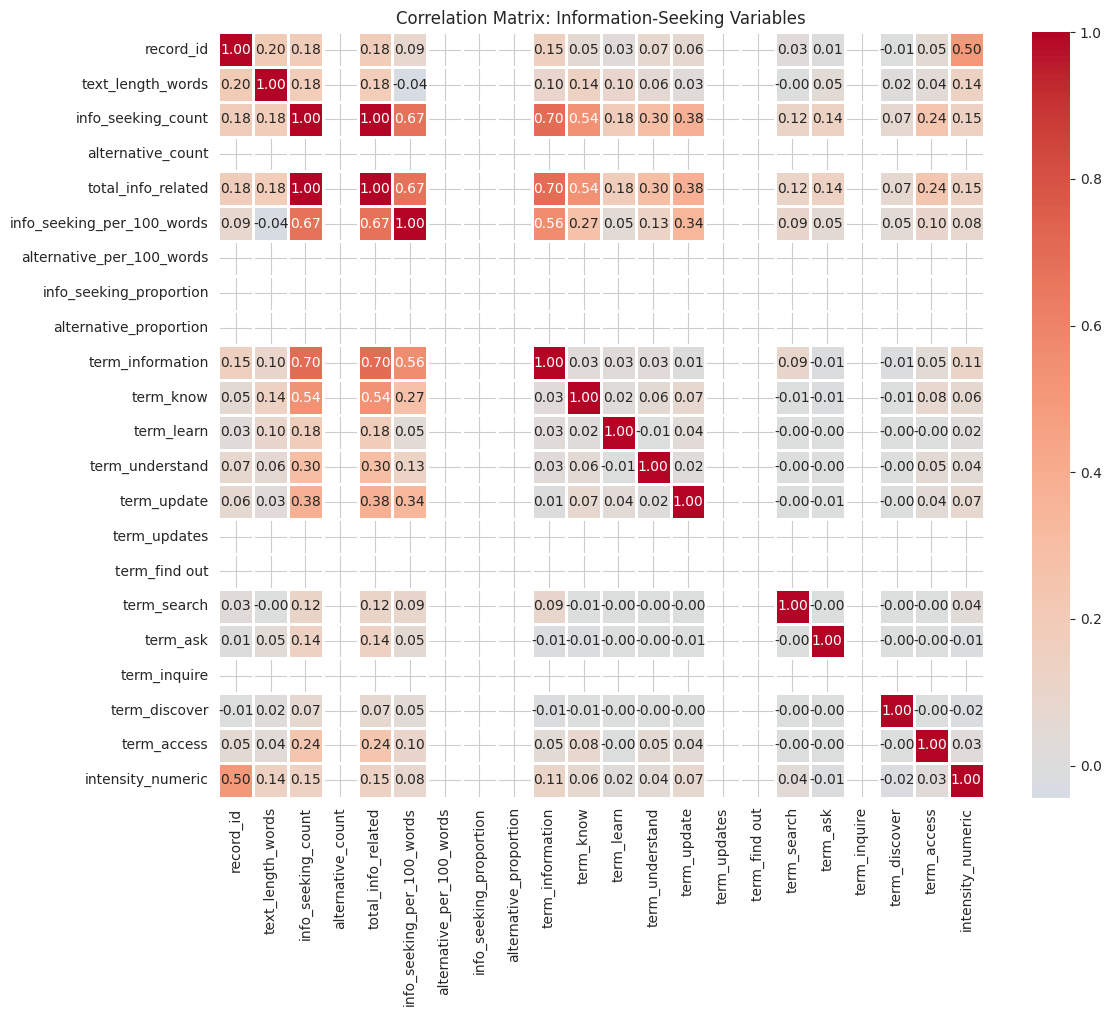

<Figure size 1200x600 with 0 Axes>

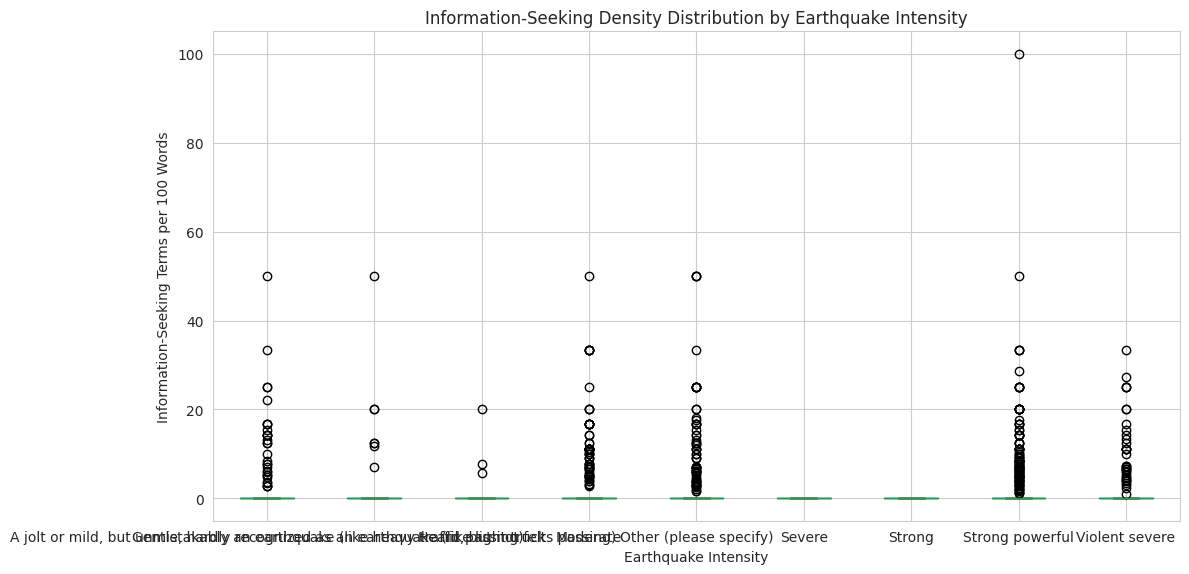

In [41]:
# Cell 12: Additional custom visualisations

if analysis_results is not None:
    # Correlation heatmap (if numeric variables available)
    numeric_cols = analysis_results.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 3:
        plt.figure(figsize=(12, 10))
        correlation_matrix = analysis_results[numeric_cols].corr()
        sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                    center=0, square=True, linewidths=1)
        plt.title('Correlation Matrix: Information-Seeking Variables')
        plt.tight_layout()
        plt.show()

    # Box plot: Intensity vs Information-Seeking
    if 'intensity' in analysis_results.columns:
        plt.figure(figsize=(12, 6))
        analysis_results.boxplot(column='info_seeking_per_100_words', by='intensity',
                          figsize=(12, 6))
        plt.suptitle('')
        plt.title('Information-Seeking Density Distribution by Earthquake Intensity')
        plt.xlabel('Earthquake Intensity')
        plt.ylabel('Information-Seeking Terms per 100 Words')
        plt.tight_layout()
        plt.show()